<a href="https://www.kaggle.com/code/samyak15jain/textcnn-with-roberta?scriptVersionId=135886859" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt


In [2]:
import nltk

# Download all NLTK resources
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [3]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ [y]

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
caution: filename not matched:  [y]


In [4]:
# from torchtext import vocab
# vec = vocab.Vectors('glove.6B.100d.txt', '../input/glove6b100dtxt/')

In [5]:
import wandb

wandb.init(project='MYM TWEETS ANALYSIS')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import random
import nltk
import torchtext.vocab
from nltk.corpus import wordnet
from torchtext.vocab import GloVe
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Load the dataset
abortion = load_dataset("tweet_eval", "stance_abortion")
train_ds = abortion["train"]
valid_ds = abortion["validation"]
test_ds = abortion["test"]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/587 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/280 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/66 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/stance_abortion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# Preprocess text (username and link placeholders)

def preprocess(text):
    pronouns = ["i", "you", "he", "she", "it", "we", "they","to","that","for","and","be","is","of","in","are","your","their"]
    articles = ["a", "an", "the"]
    
    new_text = []
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        if t.lower() not in pronouns and t.lower() not in articles:
            new_text.append(t)
    return " ".join(new_text)

In [9]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
def remove_stopwords(text):
    text=' '.join([word.lower() for word in text.split() if word.lower() not in stop])
    return text

In [10]:
# Tokenize the dataset
task='sentiment'
MODEL = "cardiffnlp/twitter-roberta-base-stance-abortion"
max_length = 64
tokenizer = AutoTokenizer.from_pretrained(MODEL)

train_texts = [preprocess(text) for text in train_ds["text"]]
valid_texts = [preprocess(text) for text in valid_ds["text"]]
test_texts = [preprocess(text) for text in test_ds["text"]]

In [11]:
# train_texts

In [12]:
import spacy

nlp = spacy.load('en_core_web_sm')

# Lemmatize the data
lemmatized_train_texts = []
lemmatized_test_texts = []
lemmatized_valid_texts = []

for text in train_texts:
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    lemmatized_train_texts.append(' '.join(lemmatized_words))
    
for text in test_texts:
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    lemmatized_test_texts.append(' '.join(lemmatized_words))
    
for text in valid_texts:
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    lemmatized_valid_texts.append(' '.join(lemmatized_words))

# Assign the lemmatized data to the respective variables
train_text = lemmatized_train_texts
test_text = lemmatized_test_texts
valid_text = lemmatized_valid_texts

# print(train_text)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [13]:
# lemmatized_train_texts

In [14]:
train_encodings = tokenizer(train_text, padding="max_length", truncation=True, max_length=max_length)
valid_encodings = tokenizer(valid_text, padding="max_length", truncation=True, max_length=max_length)
test_encodings = tokenizer(test_text, padding="max_length", truncation=True, max_length=max_length)

In [15]:
# tokenizer.get_vocab()

In [16]:
# Get pre-trained word embeddings (GloVe)
import torch
import numpy as np

glove_file = '/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt'
word_embeddings = {}
with open(glove_file, encoding="utf8") as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype=np.float32)
        word_embeddings[word] = embedding

embedding_dim = len(list(word_embeddings.values())[0])
token_vocab = tokenizer.get_vocab()

word_embeddings_list = []
for word, index in token_vocab.items():
    if word in word_embeddings:
        word_embeddings_list.append(torch.tensor(word_embeddings[word]))
    else:
        word_embeddings_list.append(torch.zeros(embedding_dim))

word_embeddings_tensor = torch.stack(word_embeddings_list)


In [17]:
# print(word_embeddings_list)

In [18]:
# Create data loaders
import torch
import torch.nn as nn
batch_size = 256

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings["input_ids"]),
                                               torch.tensor(train_encodings["attention_mask"]),
                                               torch.tensor(train_ds["label"]))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(valid_encodings["input_ids"]),
                                               torch.tensor(valid_encodings["attention_mask"]),
                                               torch.tensor(valid_ds["label"]))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings["input_ids"]),
                                               torch.tensor(test_encodings["attention_mask"]),
                                               torch.tensor(test_ds["label"]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [19]:
train_dataset

In [20]:
import torch
import torch.nn as nn

class TextCNN(nn.Module):
    def __init__(self, input_size, embed_size, kernel_sizes, num_channels, word_embeddings):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_size, num_channels, kernel_size)
            for kernel_size in kernel_sizes
        ])
        self.fc_layers = nn.Sequential(
            nn.Linear(len(kernel_sizes) * num_channels, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_length, embed_size)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embed_size, seq_length)
        conv_outputs = [torch.relu(conv(embedded)) for conv in self.convs]  # [(batch_size, num_channels, seq_length - kernel_size + 1), ...]
        pooled_outputs = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_outputs]  # [(batch_size, num_channels), ...]
        cat = torch.cat(pooled_outputs, dim=1)  # (batch_size, len(kernel_sizes) * num_channels)
        output = self.fc_layers(cat)
        return output

In [21]:
# Define the model

# model = TextCNN(input_size=len(tokenizer.get_vocab()), embed_size=100, kernel_sizes=[3, 4, 5], num_channels=256)
model = TextCNN(input_size=len(tokenizer.get_vocab()), embed_size=100, kernel_sizes=[3, 4, 5], num_channels=256, word_embeddings=word_embeddings_tensor)
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
# Move the models to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
roberta_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [23]:
# Define training parameters
learning_rate = 5e-5
batch_size = 256
epochs = 5

In [24]:
# Define optimizer and loss function
class_counts = np.bincount(train_ds["label"])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32)
class_weights = class_weights.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(class_weights)

config = wandb.config
config.learning_rate = learning_rate
config.batch_size = batch_size
config.epochs = epochs
wandb.watch(model)
wandb.watch(roberta_model)

[]

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the RoBERTa model
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)
roberta_model.to(device)

# Configure the optimizer and loss function
optimizer = torch.optim.AdamW(roberta_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
best_f1_score = 0.0

for epoch in range(num_epochs):
    roberta_model.train()  # Set model to training mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate metrics
    train_loss = total_loss / total_samples
    train_accuracy = total_correct / total_samples

    # Evaluation on the validation set
    roberta_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = criterion(logits, labels)

            # Update statistics
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)

    # Calculate metrics
    val_loss = val_loss / val_samples
    val_accuracy = val_correct / val_samples

    # Print epoch statistics
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10:
Train Loss: 0.6018, Train Accuracy: 0.7325
Val Loss: 0.5260, Val Accuracy: 0.8182
Epoch 2/10:
Train Loss: 0.5132, Train Accuracy: 0.7871
Val Loss: 0.5413, Val Accuracy: 0.8182
Epoch 3/10:
Train Loss: 0.5055, Train Accuracy: 0.7853
Val Loss: 0.5228, Val Accuracy: 0.8030
Epoch 4/10:
Train Loss: 0.4348, Train Accuracy: 0.8365
Val Loss: 0.5102, Val Accuracy: 0.8333
Epoch 5/10:
Train Loss: 0.4195, Train Accuracy: 0.8467
Val Loss: 0.5068, Val Accuracy: 0.8182
Epoch 6/10:
Train Loss: 0.4081, Train Accuracy: 0.8467
Val Loss: 0.5098, Val Accuracy: 0.8333
Epoch 7/10:
Train Loss: 0.3735, Train Accuracy: 0.8739
Val Loss: 0.5370, Val Accuracy: 0.7879
Epoch 8/10:
Train Loss: 0.3494, Train Accuracy: 0.8671
Val Loss: 0.5923, Val Accuracy: 0.7727
Epoch 9/10:
Train Loss: 0.3300, Train Accuracy: 0.8722
Val Loss: 0.6280, Val Accuracy: 0.7727
Epoch 10/10:
Train Loss: 0.3081, Train Accuracy: 0.8893
Val Loss: 0.6235, Val Accuracy: 0.7879


In [26]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        cnn_outputs = model(input_ids)
        roberta_outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = cnn_outputs + roberta_outputs.logits

        loss = loss_fn(logits, labels)
        train_loss += loss.item()
        wandb.log({"Train Loss": loss.item()})

        loss.backward()
        optimizer.step()

        _, predicted_labels_batch = torch.max(logits, dim=1)
        train_acc += accuracy_score(labels.cpu().numpy(), predicted_labels_batch.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    predicted_labels = []

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            cnn_outputs = model(input_ids)
            roberta_outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = cnn_outputs + roberta_outputs.logits

            valid_loss += loss_fn(logits, labels).item()
            wandb.log({"Valid Loss": loss_fn(logits, labels).item()})

            _, predicted_labels_batch = torch.max(logits, dim=1)
            predicted_labels.extend(predicted_labels_batch.cpu().numpy())

            valid_acc += accuracy_score(labels.cpu().numpy(), predicted_labels_batch.cpu().numpy())
            wandb.log({"Train Accuracy": train_acc, "Valid Accuracy": valid_acc})

    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)
    f1 = f1_score(valid_ds["label"], predicted_labels, average="weighted")

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, F1 Score: {f1:.4f}")
    print()

Epoch 1/5
Train Loss: 0.2538, Train Acc: 0.9246
Valid Loss: 0.6133, Valid Acc: 0.8030, F1 Score: 0.8104

Epoch 2/5
Train Loss: 0.2142, Train Acc: 0.9283
Valid Loss: 0.5636, Valid Acc: 0.8182, F1 Score: 0.8243

Epoch 3/5
Train Loss: 0.1786, Train Acc: 0.9309
Valid Loss: 0.5709, Valid Acc: 0.8182, F1 Score: 0.8224

Epoch 4/5
Train Loss: 0.1568, Train Acc: 0.9591
Valid Loss: 0.6128, Valid Acc: 0.8030, F1 Score: 0.8069

Epoch 5/5
Train Loss: 0.1338, Train Acc: 0.9580
Valid Loss: 0.6802, Valid Acc: 0.8182, F1 Score: 0.8243



In [27]:

# Evaluate on the test set


model.eval()
test_loss = 0.0
test_acc = 0.0
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        cnn_outputs = model(input_ids)
        roberta_outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = cnn_outputs + roberta_outputs.logits

        test_loss += loss_fn(logits, labels).item()

        _, predicted_labels_batch = torch.max(logits, dim=1)
        predicted_labels.extend(predicted_labels_batch.cpu().numpy())

        test_acc += accuracy_score(labels.cpu().numpy(), predicted_labels_batch.cpu().numpy())

test_loss /= len(test_loader)
test_acc /= len(test_loader)
f1 = f1_score(test_ds["label"], predicted_labels, average="weighted")

print("Test Results:")
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, F1 Score: {f1:.4f}")

Test Results:
Test Loss: 0.6854, Test Acc: 0.7878, F1 Score: 0.6648


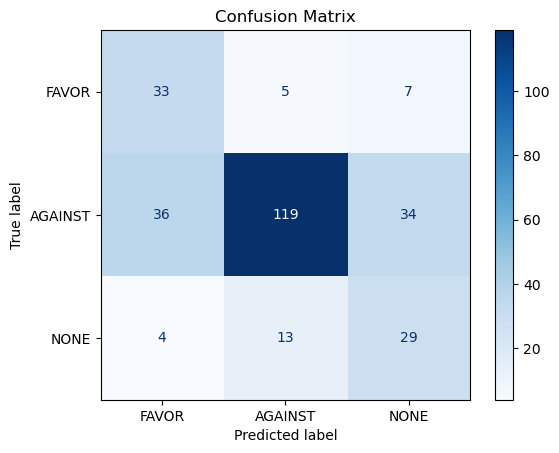

In [28]:
# Generate confusion matrix
cm = confusion_matrix(test_ds["label"], predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAVOR", "AGAINST", "NONE"])
cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import urllib.request

# Define the sample input text
sample_text = "abortion is best"

# Preprocess text (username and link placeholders)
def preprocess(text):
    pronouns = ["i", "you", "he", "she", "it", "we", "they","to","that","for","and","be","is","of","in","are","your","their"]
    articles = ["a", "an", "the"]
    
    new_text = []
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        if t.lower() not in pronouns and t.lower() not in articles:
            new_text.append(t)
    return " ".join(new_text)

preprocessed_text = preprocess(sample_text)
print(preprocessed_text)

import spacy

nlp = spacy.load('en_core_web_sm')

# Lemmatize the data
lemmatized_train_texts = []

for text in preprocessed_text.split(" "):
    doc = nlp(text)
#     lemmatized_words = [token.lemma_ for token in doc]
#     text = token.lemma_ for token in doc
    lemmatized_train_texts.append(token.lemma_ for token in doc)
print(lemmatized_train_texts)

# Preprocess the sample input text


# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-stance-abortion")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-stance-abortion")

# Tokenize the sample input text
encoded_input = tokenizer(lemmatized_train_texts, return_tensors='pt')

# Forward pass through the model
with torch.no_grad():
    output = model(**encoded_input)

# Get the predicted label and score
predicted_label = torch.argmax(output.logits, dim=1).item()
predicted_score = torch.softmax(output.logits, dim=1).tolist()[0]

# Get the label mapping
mapping_link = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt"
response = urllib.request.urlopen(mapping_link)
label_mapping = response.read().decode('utf-8').split("\n")
label_mapping = [row.split('\t') for row in label_mapping if len(row) > 0]

# Map the predicted label to the corresponding sentiment
predicted_sentiment = label_mapping[predicted_label][1]

# Print the results
print("Sample Text:", sample_text)
print("Predicted Sentiment:", predicted_sentiment)
print("Predicted Score:", predicted_score)

abortion best
[<generator object <genexpr> at 0x7d3b99f79070>, <generator object <genexpr> at 0x7d3b99f79000>]


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# from wordcloud import WordCloud,STOPWORDS

In [ ]:
# plt.figure(figsize = (15,15)) # Text that is not Fake
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(train_df[train_df.label == 1].text))
# plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
# pip install wordcloud

In [35]:
all_text = train_text + valid_text + test_text
# all_text

In [36]:
from collections import Counter
flattened_texts = [word for sublist in all_text for word in sublist]
string = ''.join(flattened_texts)
newlist = string.split(' ')
word_frequencies = {}
for i in newlist:
    if i in word_frequencies:
        word_frequencies[i] +=1
    else:
        word_frequencies[i] = 1
        
# print(word_frequencies)

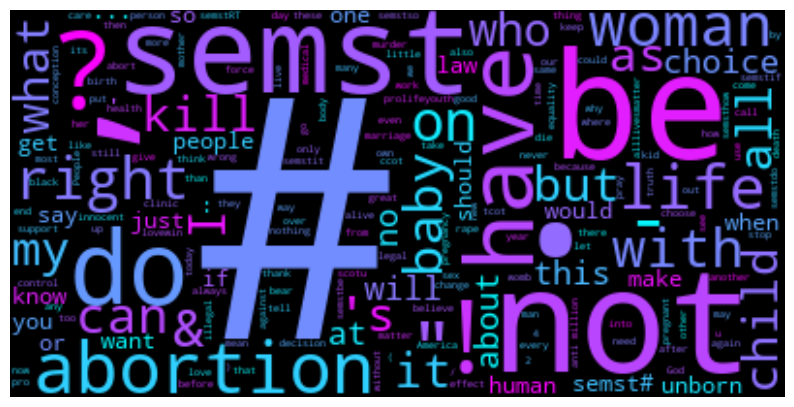

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(max_words=1000, background_color='black', colormap='cool').generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()